# Univariate Risk Management

## Done by: Alexander Tashchyan

### 1. Downloading nessesary packages

In [24]:
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats as ss
import scipy
import statsmodels.graphics.gofplots

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance
import arch
%matplotlib inline

alpha = 0.05

### 2. Downloading, processing and visualisation the data from YFinance (the most user friendly API)

In [3]:
df = yfinance.download("MSFT", '2017-07-01','2020-06-30') #Microsoft Stock prices from 2017 to 2020

df.head() #Look at the dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-30,68.779999,69.379997,68.739998,68.930000,64.563553,24161100
2017-07-03,69.330002,69.599998,68.019997,68.169998,63.851692,16165500
2017-07-05,68.260002,69.440002,68.220001,69.080002,64.704056,21176300
2017-07-06,68.269997,68.779999,68.120003,68.570000,64.226357,21117600
2017-07-07,68.699997,69.839996,68.699997,69.459999,65.059975,16878300


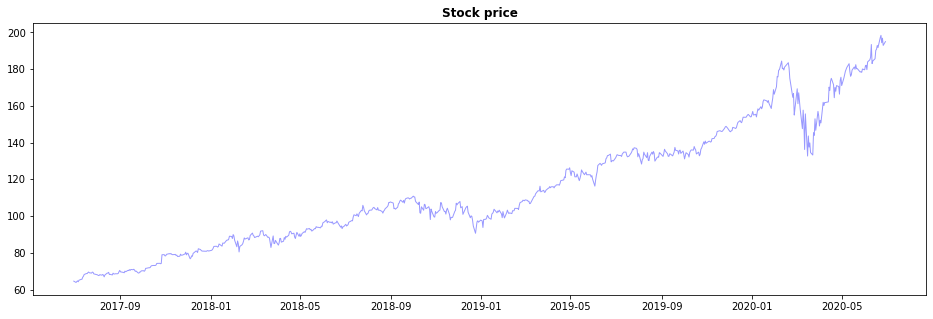

In [4]:
## Plot the Stock price chart

fig = plt.figure(figsize=(16, 5)) #Set size
plt.plot(df["Adj Close"], color = "b", alpha = 0.4, lw = 1) #Set parameters
plt.title("Stock price", weight="bold") #Chart title
plt.show()

In [5]:
df.index = df.index.to_period(freq='d') #Indexing
price = df['Adj Close'] #Adjusted Prices
ret = price.pct_change() #Percent changes
ret = ret.dropna() #Drop Nans in returns
ret.head()

Date
2017-07-03   -0.011026
2017-07-05    0.013349
2017-07-06   -0.007383
2017-07-07    0.012979
2017-07-10    0.007486
Freq: D, Name: Adj Close, dtype: float64

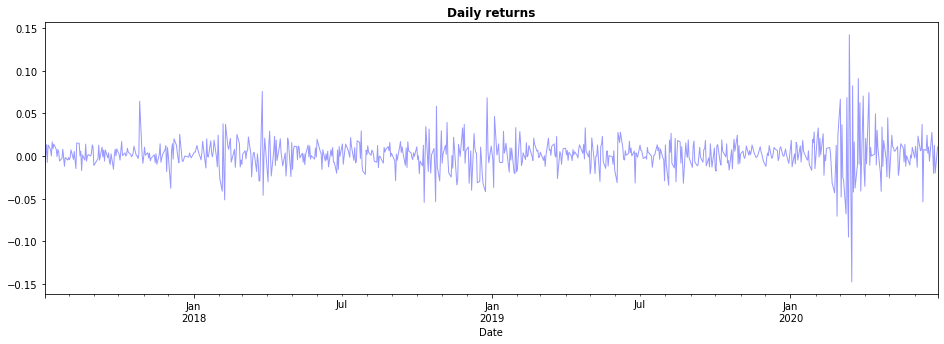

In [6]:
## Plotting Returns

fig = plt.figure(figsize=(16, 5)) #Set figure size

ret.plot(color = "b", alpha = 0.4, lw = 1)
plt.title("Daily returns", weight="bold")

plt.show()

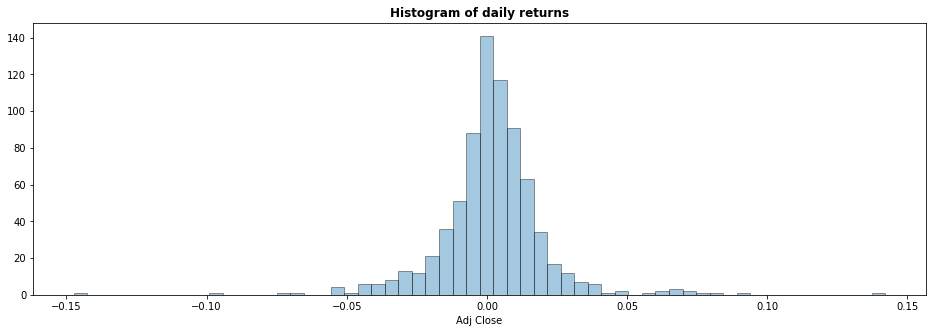

In [27]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

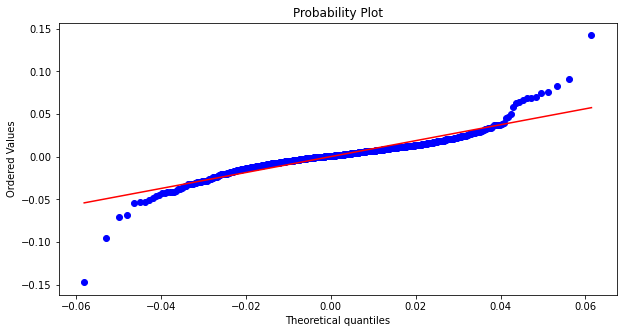

In [23]:
fig = plt.figure(figsize=(10, 5))

params_norm = ss.norm.fit(ret)
ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)

plt.show()

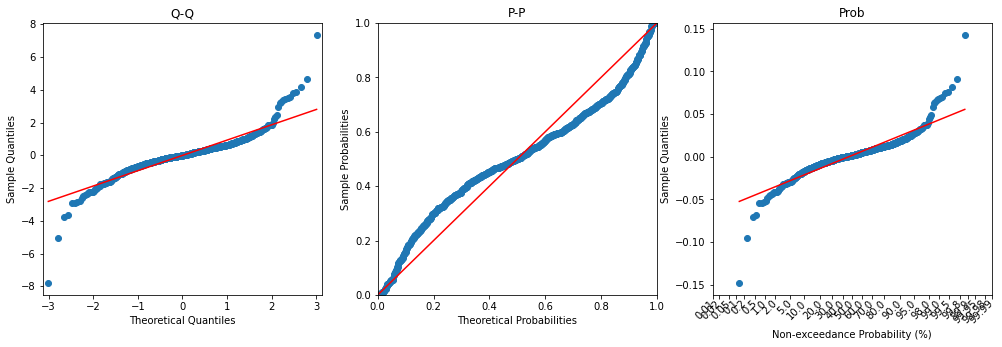

In [25]:
pp = statsmodels.graphics.gofplots.ProbPlot(ret, fit=True)

fig = plt.figure(figsize=(17, 5))

plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

pp.qqplot(ax=plt1.axes, line='r')
plt1.set_title('Q-Q')

pp.ppplot(ax=plt2.axes, line='45')
plt2.set_title('P-P')

pp.probplot(ax=plt3.axes, line='r')
plt3.set_title('Prob')

plt.show()

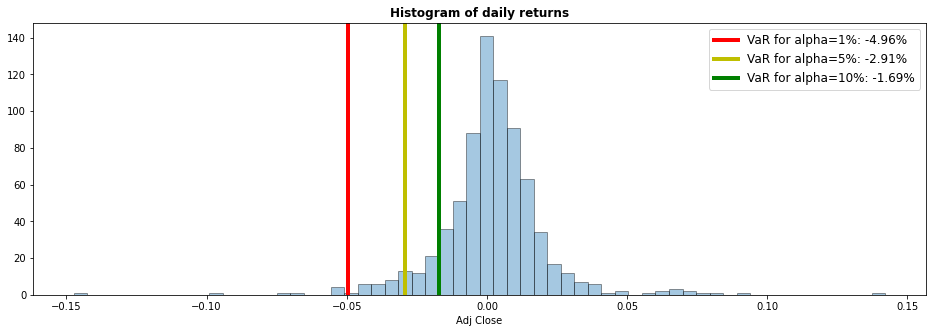

In [26]:
VaR_HS_01 = ret.quantile(0.01)
VaR_HS_05 = ret.quantile(0.05)
VaR_HS_10 = ret.quantile(0.10)

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
plt.axvline(x=VaR_HS_05, linewidth=4, color="y")
plt.axvline(x=VaR_HS_10, linewidth=4, color="g")

plt.title("Histogram of daily returns", weight="bold")

plt.legend(['VaR for alpha=1%: {:.2f}%'.format(100*VaR_HS_01),
            'VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS_05),
            'VaR for alpha=10%: {:.2f}%'.format(100*VaR_HS_10)], fontsize=12)

plt.show()

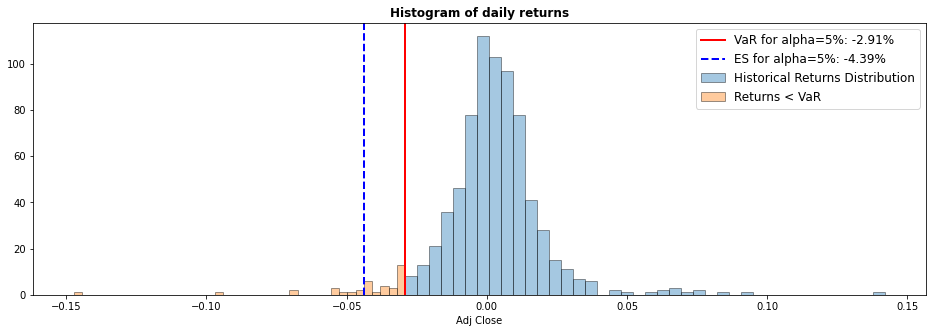

In [31]:
alpha = 0.05

VaR_HS = ret.quantile(alpha)
ES_HS = ret[ret < VaR_HS].mean()

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS, linewidth=2, color="r")
plt.axvline(ES_HS, linewidth=2, color='b', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS),
            'ES for alpha=5%: {:.2f}%'.format(100*ES_HS),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

### 3. VaR with GARCH with constant mean

In [7]:
##Determining VaR function (basic function)

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan) #Create matrix
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [9]:
##Univariate VaR function with GARCH

def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch.arch_model(scaling_const * returns,
                    mean='Constant', # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

In [10]:
VaR_GARCH = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)

### 4. EGARCH with tol 1e-01

In [13]:
##Univariate VaR function with GARCH

def calculate_VaR_Egarch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch.arch_model(scaling_const * returns,
                    mean='Constant',# mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off', tol=1e-01, options={'max_iter': 10000})

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

In [14]:
VaR_EGARCH = calc_VaR(ret, calculate_VaR_Egarch, L_history=252, level=alpha)

### 5. VaR with Generalized Normal

In [15]:
##Univariate VaR function with Generalized Normal

def calculate_VaR_generalized_normal(returns, alpha=0.05):

    params_norm = ss.gennorm.fit(returns)
    
    return ss.gennorm.ppf(alpha, *params_norm)

In [16]:
VaR_GN = calc_VaR(ret, calculate_VaR_generalized_normal, L_history=252, level=alpha)

### 6. VaR with GARCH FHS and EVT

In [17]:
##Univariate VaR function using Extreme Value Theorem and Historical Simulation

def calculate_VaR_FHS_POT(returns, alpha):
    
    dist = 'skewstudent'
    
    scaling_const = 10.0 / returns.std()

    mdl = arch.arch_model(scaling_const * returns,
                    mean='Constant',
                    vol='Garch', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist)

    res = mdl.fit(disp='off')

   # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const


    u = conditional_sr.quantile(0.2)
    ret_tail = conditional_sr[conditional_sr <= u]
    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    VaR_FHS_POT = u - scale / c * ((alpha/(conditional_sr <= u).mean())**(-c) - 1)

    return VaR_FHS_POT

In [18]:
VaR_FHS_POT1 = calc_VaR(ret, calculate_VaR_FHS_POT, L_history=252, level=alpha)

### 7. Backtesting

The idea of this sections is to test the effectiveness for several proposed models. The implementation is the following:

* Calculate hits of the assets, where hit is 1 if the return is less then the Forecasted VaR  and 0 otherwise
* We have binomial distribution for number of hits
* We calculate proportion of hits and compare in with p-value

In [19]:
## Hit Calculation

def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [20]:
## Backtesting VaR

def backtest_VaR(r, VaR, level, L=None):

    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')

### 8. Results

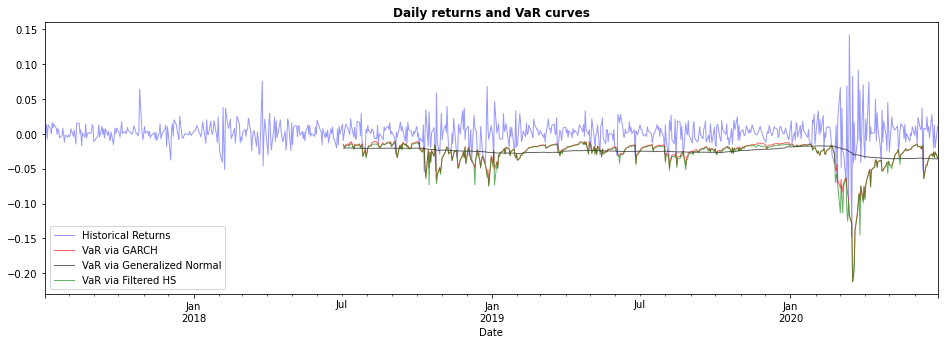

In [21]:
fig = plt.figure(figsize=(16, 5)) # figure size

ret.plot(color = "b", alpha = 0.4, lw = 1)

VaR_GARCH.plot(color = "r", alpha = 0.6, lw = 1) #Red coloured GARCH-based VaR

VaR_GN.plot(color = "black", alpha = 0.6, lw = 1) #Black coloured Generalised Normal VaR

VaR_FHS_POT1.plot(color = "green", alpha = 0.6, lw = 1) # Green coloured EVT VaR and Historical Simulation

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via GARCH',
           'VaR via Generalized Normal',
           'VaR via Filtered HS'])

plt.show()

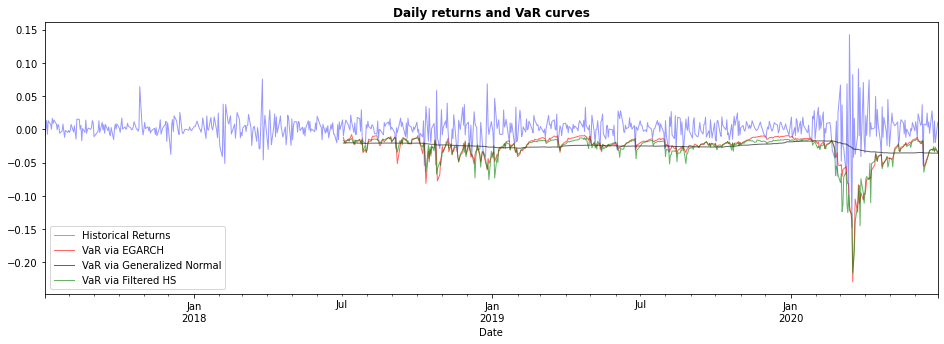

In [63]:
fig = plt.figure(figsize=(16, 5))

ret.plot(color = "b", alpha = 0.4, lw = 1)

VaR_EGARCH.plot(color = "r", alpha = 0.6, lw = 1)

VaR_GN.plot(color = "black", alpha = 0.6, lw = 1)

VaR_FHS_POT1.plot(color = "green", alpha = 0.6, lw = 1)



plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via EGARCH',
           'VaR via Generalized Normal',
           'VaR via Filtered HS'])

plt.show()

In [16]:
backtest_VaR(ret, VaR_GARCH, 1-alpha)

Backtesting calculate_VaR_garch:
The proportion of hits is 5.79% instead of expected 5.0%
Two-sided p-val 0.411, one-sided: 0.235


In [62]:
backtest_VaR(ret, VaR_EGARCH, 1-alpha)

Backtesting calculate_VaR_Egarch:
The proportion of hits is 6.79% instead of expected 5.0%
Two-sided p-val 0.08, one-sided: 0.0465


In [17]:
backtest_VaR(ret, VaR_GN, 1-alpha)

Backtesting calculate_VaR_generalized_normal:
The proportion of hits is 7.78% instead of expected 5.0%
Two-sided p-val 0.0073, one-sided: 0.00476


In [18]:
backtest_VaR(ret, VaR_FHS_POT1, 1-alpha)

Backtesting calculate_VaR_FHS_POT:
The proportion of hits is 5.59% instead of expected 5.0%
Two-sided p-val 0.538, one-sided: 0.3


### 9. Conclusion

The most effective method for stock retuns is a combination of GARCH-EVT methods, as the proortion of hits is minimal, so the model effectively forecasted VaR for the stock returns